In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import scipy as sp
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [3]:
data = pd.read_csv('../data/Trolley.csv', sep=';')
data.sample(5)

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
2299,ikbur,5,13,96;817,18,0,High School Graduate,1,1,0,bur,1
7707,ilshi,1,26,97;773,39,1,Some High School,0,1,0,shi,0
2189,nfrub,6,7,96;802,21,0,Some College,1,0,0,rub,1
3200,ikpon,1,20,96;997,56,1,Graduate Degree,1,1,0,pon,1
4599,fkbur,1,14,97;350,24,0,Bachelor's Degree,1,0,0,bur,1


**H5** One hypothesis from developmental psychology, usually attributed to Carol Gilligan, proposes that women and men have different average tendencies in moral reasoning. Like most hypotheses in social psychology, it is merely descriptive. The notion is that women are more concerned with care (avoiding harm), while men are more concerned with justice and rights. 

Evaluate this hypothesis, using the `Trolley` data, supposing that contact provides a proxy for physical harm. Are women more or less bothered by contact than are men, in these data? Figure out the model(s) that is needed to address this question.

In [5]:
with pm.Model() as m_h5:
    cutpoints = pm.Normal(
        'cutpoints', mu=0, sd=3,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.linspace(-2, 3, 6))

    beta_contact = pm.Normal('beta_contact', mu=0, sd=1)
    beta_male = pm.Normal('beta_male', mu=0, sd=1)
    beta_male_contact = pm.Normal('beta_male_contact', mu=0, sd=1)

    phi = (
        beta_contact * data.contact.values
        + beta_male * data.male.values
        + beta_male_contact * (data.contact.values * data.male.values)
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=data.response - 1
    )

    m_h5.name = 'male vs contact'
    m_h5.trace = pm.sample(5000, tune=2000, chains=2)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_male_contact, beta_male, beta_contact, cutpoints]
Sampling 2 

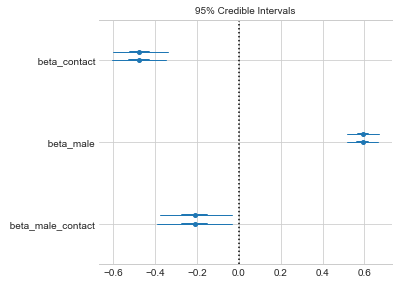

In [8]:
pm.forestplot(m_h5.trace,
              varnames=[ 'beta_contact', 'beta_male', 'beta_male_contact'],
              rhat=False)
None